In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const
from scipy.interpolate import interp1d

#Configuration for the font and style in the graphics
params = {
        'font.family': 'serif',
        'font.serif': ['STIXGeneral', 'Times New Roman'],
        'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'legend.fontsize': 13,
        'xtick.labelsize': 13,
        'ytick.labelsize': 13,
        'mathtext.fontset': 'stix',
        'text.usetex': False,
        'figure.figsize': (6.4, 4.8),
        'savefig.format': 'pdf',
        'savefig.bbox': 'tight'
    }
    
plt.rcParams.update(params)

In [108]:
#Lines from the excel
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\Visualizer\Clean lines\Nave list NIR.xlsx")
raw_lambda['Nave list'] = (10**8)/raw_lambda['lambda']
raw_lambda = raw_lambda[raw_lambda['Nave list'].between(3950,9120,inclusive='right')] #Separate the range for use

In [ ]:
# Values.to_excel('valores_Nave.xlsx',index=False)
#Save the data before the code

In [109]:
#Data from vizier without treatment
# raw_data = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\Visualizer\Datos_prueba.xlsx")

raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\NIR_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])

#Convert the wavelength in A cause its in cm^-1 
raw_data['Wave A'] = (10**(8))/raw_data['Wave (cm)']

#Invert the values for the index in python
raw_data = raw_data.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

In [110]:
#Lines from the excel
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\Visualizer\Clean lines\Nave list NIR.xlsx")
raw_lambda['Nave list'] = (10**8)/raw_lambda['lambda']
raw_lambda = raw_lambda[raw_lambda['Nave list'].between(10000,23000,inclusive='right')]
raw_lambda = raw_lambda[raw_lambda['class']=='A'].reset_index(drop=True)

raw_lambda

,lambda,class,Nave list
0,9977.511,A,10022.539690
1,9975.027,A,10025.035521
2,9971.253,A,10028.829877
3,9964.517,A,10035.609353
4,9955.970,A,10044.224721
...,...,...,...
1849,4378.553,A,22838.595308
1850,4375.952,A,22852.170225
1851,4368.958,A,22888.752879
1852,4354.970,A,22962.270693


### Find the minimums and the closer line of the Fe I line


In [111]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Nave list'] = lamda
    closer_data = closer_data[closer_data['abs'] <= 0.01].reset_index(drop=True)

    return closer_data.drop(['abs'],axis=1)

#Closer lines
closer_lines = find_minimums(raw_data['Wave A'],raw_data['nFlux'],raw_lambda['Nave list'])

In [112]:
#Localize the line and save the width for lines
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points

local_points = width_minimums(closer_lines,raw_data,0.05)
local_points_bis = width_minimums(closer_lines,raw_data,0.2)

### Filter for the lines using the second derivate

In [115]:
def Fit_derivates(local_points,closer_lines,local_points_bis):
    values = []
    fit = []
    local = []
    bisector = []

    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of lines 

        #Internal rise, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #take the conditional for the division in zero

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second

        #Take more points for the fit
        new_wave = np.linspace(min(wave_scaled),max(wave_scaled),100)
        flux_fit = poly.polyval(new_wave,param) #Evaluate the fit

        #First condition: The parameter of the order two polynomium need to be positive.
        #Second condition (for eliminate lineal terms): The distance between the initial and the final point need to be less than the half of depth
        #In other words, the final point need to be higher than the half of the distance between extreme points
  
        if d2_param[0]>0 and (data_flux.iloc[-1])>=(np.abs(data_flux.iloc[0]-data_flux.iloc[-1])/2):
    
            values.append(pd.DataFrame([[closer_lines['Nave list'].iloc[i],closer_lines['min_wave'].iloc[i],closer_lines['min_flux'].iloc[i]]])) 
            fit.append(pd.DataFrame({'Flux': flux_fit,'Wave': new_wave*wave_std + wave_mean}))
            local.append(local_points[i])

            #Calculate the bisector
            data_bisec = local_points_bis[i]
            minimum = data_bisec[data_bisec['Wave A'] == closer_lines['min_wave'].iloc[i]].index[0]
            list_index = data_bisec.index.values #Take the index for the minimum.

            #Separate in two set around the minimum, a left part and a right
            left = -(min(np.abs(min(list_index) - minimum),np.abs(max(list_index) - minimum)) -1) + minimum
            right = (min(np.abs(min(list_index) - minimum),np.abs(max(list_index) - minimum)) -1) + minimum

            left_data = data_bisec.loc[left:minimum].reset_index(drop=True)
            right_data = data_bisec.loc[minimum:right].sort_values('Wave A', ascending=False).reset_index(drop=True) #arrange the wavelength

            new = pd.concat([(left_data),right_data],axis=1).drop(['Wave (cm)','rFlux'],axis=1)

            new.columns=['L flux', 'L wave','R flux','R wave']

            #Take the values for same flux interpolating the points, the dataframe doesnt count 0.3345 and 0.3344 as the same
            flux_left = interp1d(new['L flux'], new['L wave'], bounds_error=False, fill_value='extrapolate')
            flux_right = interp1d(new['R flux'], new['R wave'], bounds_error=False, fill_value='extrapolate')

            #For a reference we use the mean of fluxes on each side around the minimum
            common = np.linspace(max(new['L flux'].min(), new['R flux'].min()),min(new['L flux'].max(), new['R flux'].max()),len(new))

            #Take the wavelength data
            wave_left = flux_left(common)
            wave_right = flux_right(common)

            #The condition is take the same interpolating points
            wave_left = wave_left[(wave_left == wave_left) & (wave_right == wave_right)]
            wave_right = wave_right[(wave_left == wave_left) & (wave_right == wave_right)]
            common = common[(wave_left == wave_left) & (wave_right == wave_right)]

            #The logic is take the midpoint between wavelength at mean fluxes
            distance = (wave_right - wave_left) / 2 + wave_left
            velocity = ((distance / closer_lines['Nave list'].iloc[i]) - 1)*const.c #Express it in velocity

            bisector.append(pd.DataFrame({'Velocity': velocity,'Distance': distance,'Flux': common}).reset_index(drop=True))

    Values = pd.concat(values,axis=0).reset_index(drop=True)

    Values.columns = ["Nave line",'min_wave','min_flux']

    return Values,fit,local,bisector

Values,fit,local,bisector = Fit_derivates(local_points,closer_lines,local_points_bis)

Values

,Nave line,min_wave,min_flux
0,10022.539690,10022.532502,0.946571
1,10025.035521,10025.030255,0.957562
2,10028.829877,10028.834148,0.965678
3,10035.609353,10035.604601,0.942222
4,10067.804651,10067.811226,0.611177
...,...,...,...
521,22558.148138,22558.153410,0.987382
522,22708.605222,22708.603212,1.080441
523,22741.232743,22741.242362,1.058126
524,22776.558093,22776.564192,1.017026


## Visualizer for the Fe I lines one by one

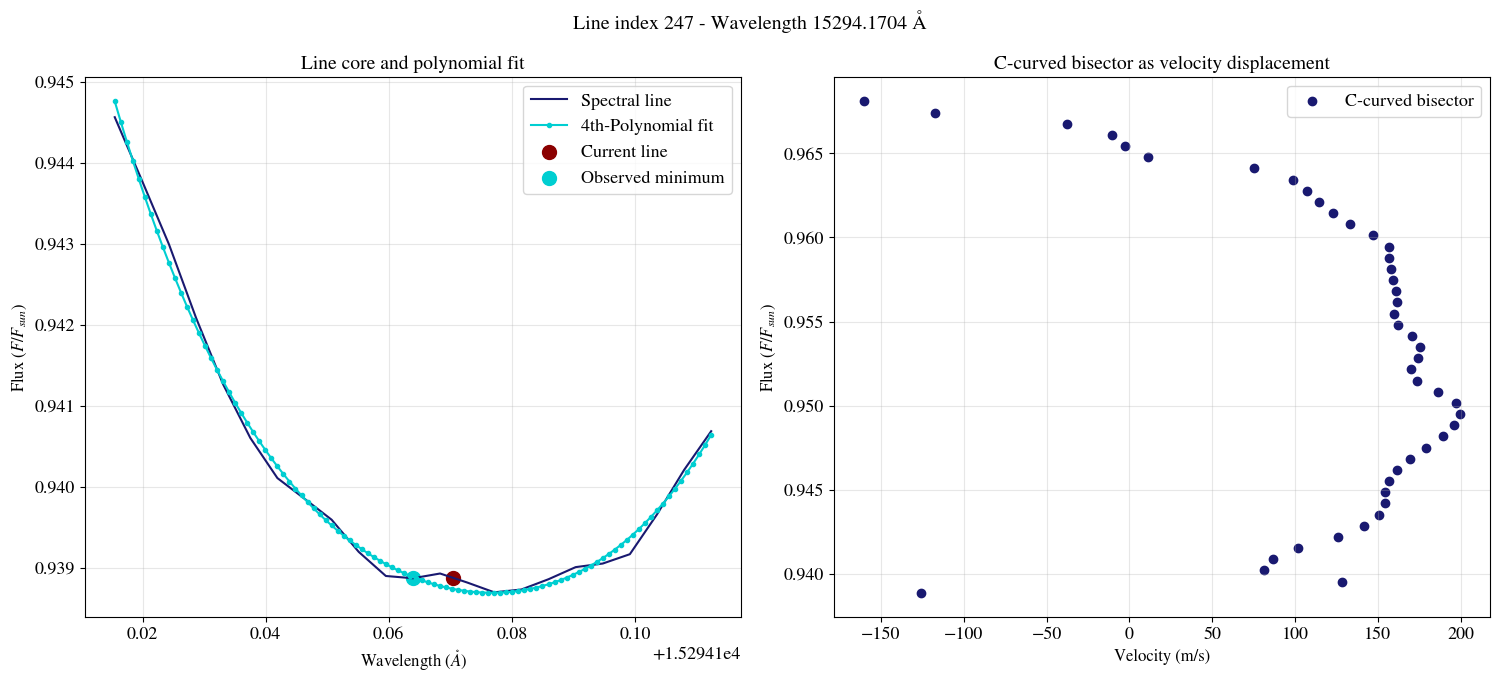

In [116]:
#Libraries for the visualizer
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk

class OutlierViewer:
    def __init__(self, root, local_points, values, fit,bisectors):
        self.root = root
        self.root.title("Visualizer for identification of calibration blendeed lines")
        self.local_points = local_points #The points of each bin around the minimum
        self.values = values #Values with ["Line Fe I", 'min_wave', 'min_flux'] for the lines which pass the first filter
        self.fit = fit #Fit values with []
        self.index = values.index.values #Index for the loop
        self.bisectors = bisectors #The list of bisectors
        self.current_index = 0
        self.star_ratings = {} #Colors for the stars labels
        self.star_labels = [] #The labels of stars

        #Dataframe for the selected lines
        self.selected_lines = pd.DataFrame({'Index': pd.Series(dtype='int64'),
        'Line': pd.Series(dtype='float64'),
        'Flux': pd.Series(dtype='float64'),
        'Classification': pd.Series(dtype='object')})
        
        self.setup_ui()
        self.update_plot()
    
    def setup_ui(self):
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.pack(fill=tk.BOTH, expand=True)
        
        #Title and stars labels
        title_frame = ttk.Frame(main_frame)
        title_frame.pack(fill=tk.X, pady=(0, 10))
        
        #Label for the title which update
        self.title_label = ttk.Label(title_frame, text="Visualizer for identification of calibration blendeed lines")
        self.title_label.pack(side=tk.LEFT)
        
        #The label stars
        self.stars_frame = ttk.Frame(title_frame)
        self.stars_frame.pack(side=tk.LEFT, padx=(10, 0))

        #Frame to have the stars buttons and the save image up
        self.buttons_frame = ttk.Frame(title_frame)
        self.buttons_frame.pack(side=tk.LEFT, padx=(20, 0))
        
        control_frame = ttk.Frame(main_frame)
        control_frame.pack(fill=tk.X, pady=10)
        
        ttk.Label(control_frame, text="Index of the line:").pack(side=tk.LEFT, padx=5)
        
        #The slider for navigating across the images
        self.slider = ttk.Scale(control_frame,from_=0,to=len(self.index)-1,orient=tk.HORIZONTAL,command=self.on_slider_move)
        self.slider.pack(side=tk.LEFT, expand=True, fill=tk.X, padx=5)
        
        #The box for write the number of the index that i want to see
        self.spinbox = ttk.Spinbox(control_frame,from_=0,to=len(self.index)-1,width=5,command=self.on_spinbox_change)
        self.spinbox.pack(side=tk.LEFT, padx=5)
        self.spinbox.bind("<Return>", self.on_spinbox_change)
        
        nav_frame = ttk.Frame(control_frame)
        nav_frame.pack(side=tk.LEFT, padx=10)
        
        #For individual check
        ttk.Button(nav_frame, text="← Last", command=self.prev_plot).pack(side=tk.LEFT)
        ttk.Button(nav_frame, text="Next →", command=self.next_plot).pack(side=tk.LEFT, padx=5)
     
        graph_frame = ttk.Frame(main_frame)
        graph_frame.pack(fill=tk.BOTH, expand=True)
       
        #Stablish the place to put the plots and the number of plots
        self.fig, self.axs = plt.subplots(1, 2, figsize=(20, 14)) #Only two, the line and the bisector
        self.ax1, self.ax2 = self.axs.flat
        self.canvas = FigureCanvasTkAgg(self.fig, master=graph_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Toolbar standard
        self.toolbar = NavigationToolbar2Tk(self.canvas, graph_frame)
        self.toolbar.update()
        self.canvas._tkcanvas.pack(fill=tk.BOTH, expand=True)

        #Stars and save button
        self.buttons(self.buttons_frame)
    
    def buttons(self, parent):
        buttons_frame = ttk.Frame(parent)
        buttons_frame.pack(fill=tk.X, pady=(20, 0))
        
        #Buttons functions
        ttk.Label(buttons_frame, text="Classification:").pack(side=tk.LEFT, padx=(0, 5))
        
        #Stars
        self.btn_green = self.create_buttons(parent, "★", "green",lambda: self.add_star("green"))
        self.btn_yellow = self.create_buttons(parent, "★", "yellow", lambda: self.add_star("yellow"))
        self.btn_red = self.create_buttons(parent, "★", "red",lambda: self.add_star("red"))
        
        #Save image
        ttk.Separator(buttons_frame, orient=tk.VERTICAL).pack(side=tk.LEFT, padx=10, fill=tk.Y)
        ttk.Button(buttons_frame, text="Save JPG", command=self.save_image).pack(side=tk.LEFT, padx=5)

        #If I want delete the selection
        ttk.Separator(buttons_frame, orient=tk.VERTICAL).pack(side=tk.LEFT, padx=10, fill=tk.Y)
        ttk.Button(buttons_frame, text="✕ Clear", command=self.delete_star).pack(side=tk.LEFT, padx=5)
    
        #If I want to add the line for a list
        ttk.Separator(buttons_frame, orient=tk.VERTICAL).pack(side=tk.LEFT, padx=10, fill=tk.Y)
        ttk.Button(buttons_frame, text="+ Add", command=self.add_line,style="Add.TButton").pack(side=tk.LEFT, padx=5)

    def create_buttons(self, parent, text, color, command):
        btn = ttk.Button(parent, text=text, command=command, width=2)
        btn.pack(side=tk.LEFT, padx=2)
        
        #Configurate color of star
        style = ttk.Style()
        style_name = f"Star.{color}.TButton"
        style.configure(style_name, foreground=color)
        btn.configure(style=style_name)
        
        return btn
    
    def save_image(self):
        #Save the current image on jpg
        try:
            #The file name is the current index and the line blended
            filename = f"fe_line_{self.current_index}_wave_{self.values['Nave line'].iloc[self.current_index]:.2f}.jpg"
            
            #Save the figure
            self.fig.savefig(filename, format='jpg', dpi=300, bbox_inches='tight', facecolor='white',edgecolor='none')
    
            #Show message of save image
            from tkinter import messagebox
            messagebox.showinfo("Good", f"Image saved as:\n{filename}")
            
        except Exception as e:
            from tkinter import messagebox
            messagebox.showerror("Error", f"Can't save the image: {str(e)}")
    
    def add_star(self, color):
        #Add the star to dictionary for stay the star
        if self.current_index not in self.star_ratings:
            self.star_ratings[self.current_index] = []
        
        self.star_ratings[self.current_index].append(color)
        
        #Update the star
        self.update_stars()

    def delete_star(self):
        if self.current_index in self.star_ratings:
            del self.star_ratings[self.current_index]
            self.update_stars()

    def update_stars(self):
        #clean the update stars
        for label in self.star_labels:
            label.destroy()
        self.star_labels = []
        
        #Show stars of the actual index
        if self.current_index in self.star_ratings:
            for color in self.star_ratings[self.current_index]:
                star_label = ttk.Label(self.stars_frame, text="★", foreground=color)
                star_label.pack(side=tk.LEFT, padx=2)
                self.star_labels.append(star_label)

    def add_line(self):
        j = self.current_index
        classification = self.star_ratings.get(self.current_index, "No rating") #The clasification, if theres nothing return NO rating
        
        #New row with the information 'Index', 'Observed minimum', 'Flux', 'Rating', 'Line'
        new_line = {'Index': self.index[j],'Line': self.values["Nave line"][j],'Flux': self.values['min_flux'][j],'Classification': classification}
        
        #Verify if theres a duplicate
        existent = self.selected_lines[ (self.selected_lines['Index'] == self.index[j]) ]
        
        if len(existent) == 0:
            #Add the new line
            self.selected_lines = pd.concat([self.selected_lines, pd.DataFrame([new_line])], ignore_index=True)
            
            #Message for confirmation
            from tkinter import messagebox
            messagebox.showinfo("Added line", f"Line {self.index[j]} added to DataFrame\n"
                              f"Wavelength: {self.values['Nave line'][j]:.4f} Å\n"
                              f"Classification: {classification}")
        else:
            #Update the existent line
            new_line = self.selected_lines.loc[existent.index[0]] 

            from tkinter import messagebox
            messagebox.showinfo("Updated line", f"Line {self.index[j]} updated in DataFrame\n"
                          f"New classification: {classification}")

    def return_lines(self):
        return self.selected_lines

    #Changes on slider, box, and index for plots
    def on_slider_move(self, event=None):
        self.current_index = int(float(self.slider.get()))
        self.spinbox.delete(0, tk.END)
        self.spinbox.insert(0, str(self.current_index))
        self.update_plot() #Update the image 
        self.update_stars() #Update the current stars classification
    
    def on_spinbox_change(self, event=None):
        try:
            new_index = int(self.spinbox.get())
            if 0 <= new_index < len(self.index):
                self.current_index = new_index
                self.slider.set(self.current_index)
                self.update_plot()
                self.update_stars()
        except ValueError:
            pass
    
    def prev_plot(self):
        if self.current_index > 0:
            self.current_index -= 1
            self.slider.set(self.current_index)
            self.spinbox.delete(0, tk.END)
            self.spinbox.insert(0, str(self.current_index))
            self.update_plot()
            self.update_stars()
    
    def next_plot(self):
        if self.current_index < len(self.index)-1:
            self.current_index += 1
            self.slider.set(self.current_index)
            self.spinbox.delete(0, tk.END)
            self.spinbox.insert(0, str(self.current_index))
            self.update_plot()
            self.update_stars()
    
    #Plots
    def update_plot(self):
        j = self.current_index
        self.ax1.clear()
        self.ax2.clear()
        
        #Plot 1 - The line and the fit
        #The original line for spectrum 
        self.ax1.plot(
            self.local_points[j]['Wave A'],
            self.local_points[j]['nFlux'],
            color='midnightblue',label='Spectral line')
        
        #The polynomial fit 
        self.ax1.plot(
            self.fit[j]['Wave'],
            self.fit[j]['Flux'],
            color='darkturquoise',label='4th-Polynomial fit',marker='.')
        
        #The line of calibration (Fe I line)
        self.ax1.scatter(
            self.values["Nave line"][j],
            self.values['min_flux'][j],
            color='darkred',label='Current line',s=100)

        #The point for the fit
        self.ax1.scatter(
            self.values['min_wave'][j],
            self.values["min_flux"][j],
            color='darkturquoise',label='Observed minimum',s=100)
   
        #Update te title on the interface
        self.ax1.set_title('Line core and polynomial fit')
        self.ax1.set_xlabel(r'Wavelength $(\mathring{A})$')
        self.ax1.set_ylabel(r'Flux $(F/F_{sun})$')
        self.ax1.grid(True, alpha=0.3)
        self.ax1.legend()
        
        # Plot 2 - The line bisector
        #The bisector
        self.ax2.scatter(
            self.bisectors[j]["Velocity"],
            self.bisectors[j]['Flux'],
            color='midnightblue',label='C-curved bisector')
        
        self.ax2.set_title(f'C-curved bisector as velocity displacement')
        self.ax2.set_xlabel(r'Velocity (m/s)')
        self.ax2.set_ylabel(r'Flux $(F/F_{sun})$')
        self.ax2.grid(True, alpha=0.3)
        self.ax2.legend()

        self.fig.tight_layout()

        #Update the big tittle
        title_text = f'Line index {self.index[j]} - Wavelength {round(self.values["Nave line"][j],4)} Å'
        self.fig.suptitle(title_text)
        self.title_label.config(text=title_text)
        self.canvas.draw()


if __name__ == "__main__":
    root = tk.Tk()
    root.geometry("900x700")
    
    #CHANGE THIS LINE - The order: local_points, values, fit,bisectors
    app = OutlierViewer(root, local,Values,fit,bisector)
    
    root.mainloop()

#This is the definitive

In [93]:
Filtered_lines_1 = app.return_lines()
Filtered_lines_1

,Index,Line,Flux,Classification
0,1,10084.1584,0.95674,[red]


In [67]:
index_to_drop_1 = Filtered_lines_1.index.values

#Drop the selected lines
New_values = Values.drop(index_to_drop_1).reset_index(drop=True)

#Save them in a excel file
# Values.to_excel('First_filter.xlsx', index=False)

## Visualizer for the check with the derivates

In [94]:
#Lines from the excel file
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Infrared range\Data\new_values_fe.xlsx")

raw_lambda

,Nave list
0,10035.6094
1,10084.1584
2,10116.7892
3,10139.8807
4,10145.6242
...,...
151,17165.7965
152,17209.0026
153,17307.0446
154,17315.5826


### Find the minimums and the closer line of the Fe I line


In [96]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Nave list'] = lamda

    return closer_data.drop(['abs'],axis=1)


closer_lines = find_minimums(raw_data['Wave A'],raw_data['nFlux'],raw_lambda['Nave list'])

closer_lines

,min_wave,min_flux,Nave list
0,10035.604601,0.942222,10035.6094
1,10084.158793,0.956740,10084.1584
2,10116.792043,0.892242,10116.7892
3,10139.882291,0.945517,10139.8807
4,10145.624806,0.916598,10145.6242
...,...,...,...
151,17165.802256,0.751678,17165.7965
152,17209.006814,0.726609,17209.0026
153,17307.053438,0.700318,17307.0446
154,17315.586883,0.928187,17315.5826


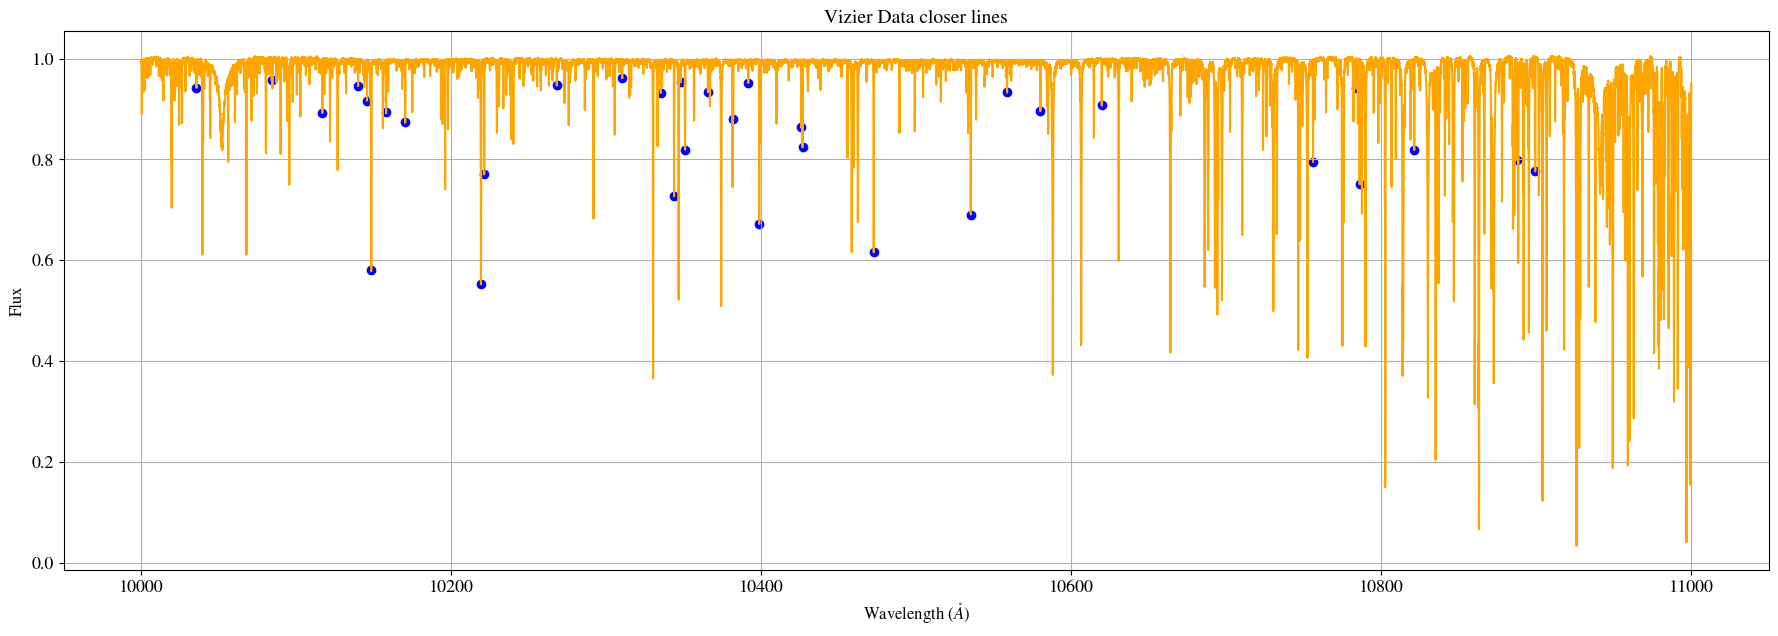

In [97]:
#Plot the identified lines
data_10000_11000 = raw_data[raw_data['Wave A'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)
closer_lines_10000_11000 = closer_lines[closer_lines['Nave list'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)

fig2, ax = plt.subplots(1,1,figsize=(22,7))
ax.plot(data_10000_11000['Wave A'],data_10000_11000['nFlux'], color='orange')
ax.scatter(closer_lines_10000_11000['min_wave'],closer_lines_10000_11000['min_flux'], color='blue')
ax.set_title('Vizier Data closer lines')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel('Flux')
ax.grid()

In [98]:
#Localize the line and save the width for lines
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points

local_points = width_minimums(closer_lines,raw_data,0.05)


### Derivates and fit

In [107]:
def Fit_derivates(local_points,lamda_list,N):
    values = []
    fit = []
    local = []

    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of Fe I lines 

        #Standarization, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #Take the conditional for the division in zero

        #Define new data with the number of points for the points, this is just for the statistical analysis
        new_wave = np.linspace(min(wave_scaled),max(wave_scaled),N)

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second
        d3_param = poly.polyder(d2_param) #Third

        #The fit values, taking into account the number of points defined on the covariance matrix
        flux_fit = poly.polyval(new_wave,param)

        #Find the minimum with the regression and derivates
        roots = poly.polyroots(d_param).real #Roots or critical points
        valid_roots = np.array([x for x in roots if poly.polyval(x,d2_param)>0] )#Check with the second derivate, just positive values for minimums
        
        if valid_roots.size >0: 

            value_roots = pol(valid_roots) #Evaluate in the polinomium for the global minimum
            minimal_root = valid_roots[np.where(value_roots == min(value_roots))][0] , min(value_roots) #Take the values for the wavelength and the flux of the minimum

            #For the wavelength observed convert the minimal root in the real with the scale of the mean, we dont scale the flux data
            lamda_obs = [round(minimal_root[0]*wave_std + wave_mean,4), minimal_root[1]]

            #Expresion for the third derivate (C-curved profile bisector)
            def Third_Derivate(second, third):
                return -((third)/(3*(second**2)))*(const.c/lamda_obs[0])

            #Evaluate the second and third derivate in the wavelength observed. Re-scalated the coefficients
            d2 = (poly.polyval(minimal_root[0],d2_param) / (wave_std ** 2)) 
            d3 = (Third_Derivate(d2, poly.polyval(minimal_root[0],d3_param) / (wave_std ** 3) )) 

            #Calculate the velocity and convective blueshift
            blueshift = ((lamda_obs[0]/lamda_list[i]) - 1)* const.c
            velocity = round((blueshift) - 633) #Formula for relativistic aproximation

            #In order: Natural wavelength, observed wavelength, flux, velocity, Core curvature, Bisector slope, convective blueshift,line depth
            values.append(pd.DataFrame([[lamda_list[i],lamda_obs[0],lamda_obs[1],velocity,d2*(lamda_obs[0]**2),d3*(const.c/lamda_obs[0]),blueshift,1-lamda_obs[1]]])) 

            #Just in case of the visualizer take the fit values and the wave data scaled
            fit.append(pd.DataFrame({'Flux': flux_fit,'Wave': new_wave*wave_std + wave_mean}))

            local.append(local_points[i])

    Values =  pd.concat(values,axis=0).reset_index(drop=True)

    Values.columns = ["Emitted wavelength", "Observed wavelength", "Flux","Velocity","Core curvature","Bisector slope","Blueshift",'Line Depth']

    return Values,local,fit

#The len(local_points) is for the original set, without statistical treatment.
Values,local,Fit = Fit_derivates(local_points,closer_lines['Nave list'],100)

Fit[78]

,Flux,Wave
0,0.569228,15625.899298
1,0.568768,15625.900227
2,0.568312,15625.901156
3,0.567861,15625.902085
4,0.567414,15625.903014
...,...,...
95,0.566205,15625.987550
96,0.566661,15625.988479
97,0.567125,15625.989408
98,0.567595,15625.990337


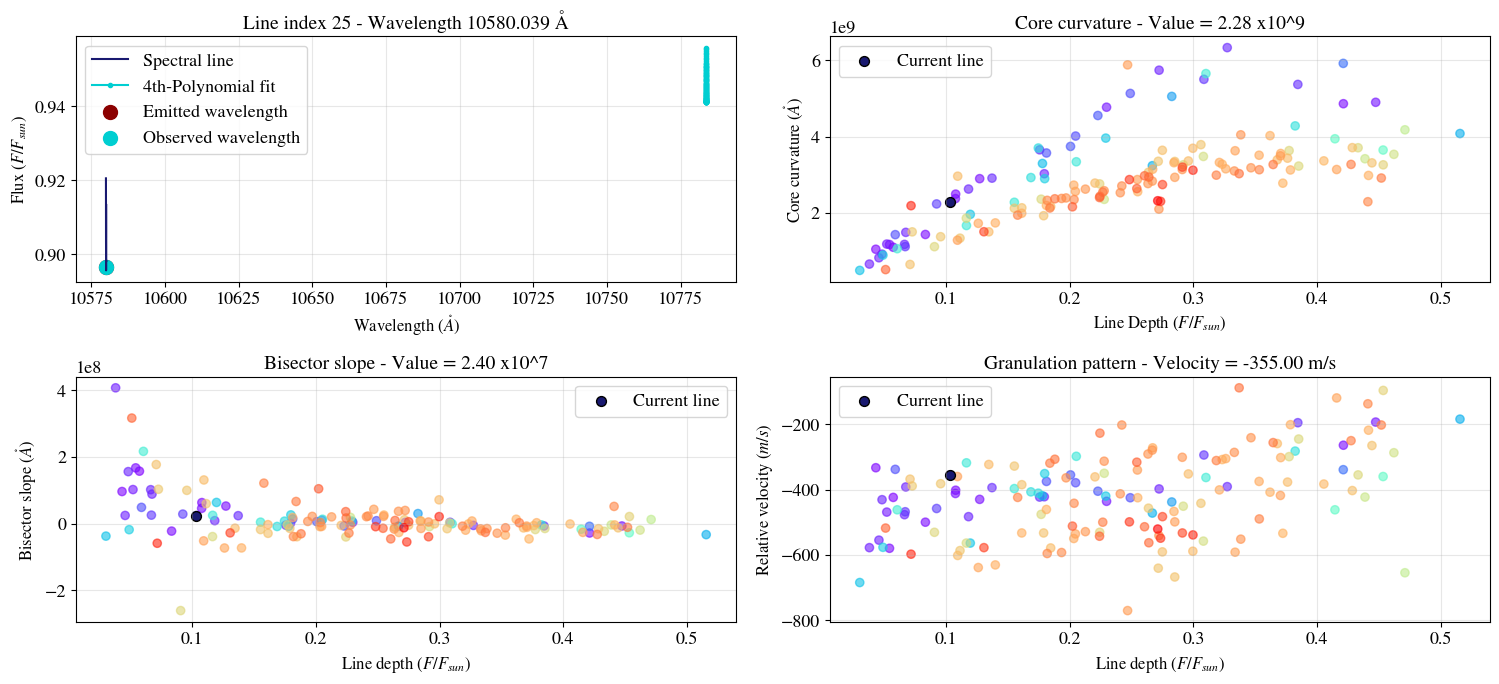

In [105]:
#Libraries for the visualizer
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk

class OutlierViewer:
    def __init__(self, root, local_points, values, fit):
        self.root = root
        self.root.title("Visualizer for identification of calibration blendeed lines")
        self.local_points = local_points #The points of each bin around the minimum
        self.values = values #Values with ["Line Fe I", 'min_wave', 'min_flux'] for the lines which pass the first filter
        self.fit = fit #Fit values with [Wave,Flux]
        self.index = values.index.values #Index for the loop
        self.current_index = 0
        self.star_ratings = {} #Colors for the stars labels
        self.star_labels = [] #The labels of stars

        #Dataframe for the selected lines
        self.selected_lines = pd.DataFrame({'Index': pd.Series(dtype='int64'),
        'Line': pd.Series(dtype='float64'),
        'Flux': pd.Series(dtype='float64'),
        'Classification': pd.Series(dtype='object')})
        
        self.setup_ui()
        self.update_plot()
    
    def setup_ui(self):
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.pack(fill=tk.BOTH, expand=True)
        
        #Title and stars labels
        title_frame = ttk.Frame(main_frame)
        title_frame.pack(fill=tk.X, pady=(0, 10))
        
        #Label for the title which update
        self.title_label = ttk.Label(title_frame, text="Visualizer for identification of calibration blendeed lines")
        self.title_label.pack(side=tk.LEFT)
        
        #The label stars
        self.stars_frame = ttk.Frame(title_frame)
        self.stars_frame.pack(side=tk.LEFT, padx=(10, 0))

        #Frame to have the stars buttons and the save image up
        self.buttons_frame = ttk.Frame(title_frame)
        self.buttons_frame.pack(side=tk.LEFT, padx=(20, 0))
        
        control_frame = ttk.Frame(main_frame)
        control_frame.pack(fill=tk.X, pady=10)
        
        ttk.Label(control_frame, text="Index of the line:").pack(side=tk.LEFT, padx=5)
        
        #The slider for navigating across the images
        self.slider = ttk.Scale(control_frame,from_=0,to=len(self.index)-1,orient=tk.HORIZONTAL,command=self.on_slider_move)
        self.slider.pack(side=tk.LEFT, expand=True, fill=tk.X, padx=5)
        
        #The box for write the number of the index that i want to see
        self.spinbox = ttk.Spinbox(control_frame,from_=0,to=len(self.index)-1,width=5,command=self.on_spinbox_change)
        self.spinbox.pack(side=tk.LEFT, padx=5)
        self.spinbox.bind("<Return>", self.on_spinbox_change)
        
        nav_frame = ttk.Frame(control_frame)
        nav_frame.pack(side=tk.LEFT, padx=10)
        
        #For individual check
        ttk.Button(nav_frame, text="← Last", command=self.prev_plot).pack(side=tk.LEFT)
        ttk.Button(nav_frame, text="Next →", command=self.next_plot).pack(side=tk.LEFT, padx=5)
     
        graph_frame = ttk.Frame(main_frame)
        graph_frame.pack(fill=tk.BOTH, expand=True)
       
        #Stablish the place to put the plots and the number of plots
        self.fig, self.axs = plt.subplots(2, 2, figsize=(20, 14))
        self.ax1, self.ax2,self.ax3, self.ax4 = self.axs.flat
        self.canvas = FigureCanvasTkAgg(self.fig, master=graph_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Toolbar standard
        self.toolbar = NavigationToolbar2Tk(self.canvas, graph_frame)
        self.toolbar.update()
        self.canvas._tkcanvas.pack(fill=tk.BOTH, expand=True)

        #Stars and save button
        self.buttons(self.buttons_frame)
    
    def buttons(self, parent):
        buttons_frame = ttk.Frame(parent)
        buttons_frame.pack(fill=tk.X, pady=(20, 0))
        
        #Buttons functions
        ttk.Label(buttons_frame, text="Classification:").pack(side=tk.LEFT, padx=(0, 5))
        
        #Stars
        self.btn_green = self.create_buttons(parent, "★", "green",lambda: self.add_star("green"))
        self.btn_yellow = self.create_buttons(parent, "★", "yellow", lambda: self.add_star("yellow"))
        self.btn_red = self.create_buttons(parent, "★", "red",lambda: self.add_star("red"))
        
        #Save image
        ttk.Separator(buttons_frame, orient=tk.VERTICAL).pack(side=tk.LEFT, padx=10, fill=tk.Y)
        ttk.Button(buttons_frame, text="Save JPG", command=self.save_image).pack(side=tk.LEFT, padx=5)

        #If I want delete the selection
        ttk.Separator(buttons_frame, orient=tk.VERTICAL).pack(side=tk.LEFT, padx=10, fill=tk.Y)
        ttk.Button(buttons_frame, text="✕ Clear", command=self.delete_star).pack(side=tk.LEFT, padx=5)
    
        #If I want to add the line for a list
        ttk.Separator(buttons_frame, orient=tk.VERTICAL).pack(side=tk.LEFT, padx=10, fill=tk.Y)
        ttk.Button(buttons_frame, text="+ Add", command=self.add_line,style="Add.TButton").pack(side=tk.LEFT, padx=5)

    def create_buttons(self, parent, text, color, command):
        btn = ttk.Button(parent, text=text, command=command, width=2)
        btn.pack(side=tk.LEFT, padx=2)
        
        #Configurate color of star
        style = ttk.Style()
        style_name = f"Star.{color}.TButton"
        style.configure(style_name, foreground=color)
        btn.configure(style=style_name)
        
        return btn
    
    def save_image(self):
        #Save the current image on jpg
        try:
            #The file name is the current index and the line blended
            filename = f"fe_line_{self.current_index}_wave_{self.values['Emitted wavelength'].iloc[self.current_index]:.2f}.jpg"
            
            #Save the figure
            self.fig.savefig(filename, format='jpg', dpi=300, bbox_inches='tight', facecolor='white',edgecolor='none')
    
            #Show message of save image
            from tkinter import messagebox
            messagebox.showinfo("Good", f"Image saved as:\n{filename}")
            
        except Exception as e:
            from tkinter import messagebox
            messagebox.showerror("Error", f"Can't save the image: {str(e)}")
    
    def add_star(self, color):
        #Add the star to dictionary for stay the star
        if self.current_index not in self.star_ratings:
            self.star_ratings[self.current_index] = []
        
        self.star_ratings[self.current_index].append(color)
        
        #Update the star
        self.update_stars()

    def delete_star(self):
        if self.current_index in self.star_ratings:
            del self.star_ratings[self.current_index]
            self.update_stars()

    def update_stars(self):
        #clean the update stars
        for label in self.star_labels:
            label.destroy()
        self.star_labels = []
        
        #Show stars of the actual index
        if self.current_index in self.star_ratings:
            for color in self.star_ratings[self.current_index]:
                star_label = ttk.Label(self.stars_frame, text="★", foreground=color)
                star_label.pack(side=tk.LEFT, padx=2)
                self.star_labels.append(star_label)

    def add_line(self):
        j = self.current_index
        classification = self.star_ratings.get(self.current_index, "No rating") #The clasification, if theres nothing return NO rating
        
        #New row with the information 'Index', 'Observed minimum', 'Flux', 'Rating', 'Line'
        new_line = {'Index': self.index[j],'Line': self.values["Emitted wavelength"][j],'Flux': self.values['Flux'][j],'Classification': classification}
        
        #Verify if theres a duplicate
        existent = self.selected_lines[ (self.selected_lines['Index'] == self.index[j]) ]
        
        if len(existent) == 0:
            #Add the new line
            self.selected_lines = pd.concat([self.selected_lines, pd.DataFrame([new_line])], ignore_index=True)
            
            #Message for confirmation
            from tkinter import messagebox
            messagebox.showinfo("Added line", f"Line {self.index[j]} added to DataFrame\n"
                              f"Wavelength: {self.values['Emitted wavelength'][j]:.4f} Å\n"
                              f"Classification: {classification}")
        else:
            #Update the existent line
            new_line = self.selected_lines.loc[existent.index[0]] 

            from tkinter import messagebox
            messagebox.showinfo("Updated line", f"Line {self.index[j]} updated in DataFrame\n"
                          f"New classification: {classification}")

    def return_lines(self):
        return self.selected_lines

    #Changes on slider, box, and index for plots
    def on_slider_move(self, event=None):
        self.current_index = int(float(self.slider.get()))
        self.spinbox.delete(0, tk.END)
        self.spinbox.insert(0, str(self.current_index))
        self.update_plot() #Update the image 
        self.update_stars() #Update the current stars classification
    
    def on_spinbox_change(self, event=None):
        try:
            new_index = int(self.spinbox.get())
            if 0 <= new_index < len(self.index):
                self.current_index = new_index
                self.slider.set(self.current_index)
                self.update_plot()
                self.update_stars()
        except ValueError:
            pass
    
    def prev_plot(self):
        if self.current_index > 0:
            self.current_index -= 1
            self.slider.set(self.current_index)
            self.spinbox.delete(0, tk.END)
            self.spinbox.insert(0, str(self.current_index))
            self.update_plot()
            self.update_stars()
    
    def next_plot(self):
        if self.current_index < len(self.index)-1:
            self.current_index += 1
            self.slider.set(self.current_index)
            self.spinbox.delete(0, tk.END)
            self.spinbox.insert(0, str(self.current_index))
            self.update_plot()
            self.update_stars()
    
    #Plots
    def update_plot(self):
        j = self.current_index
        self.ax1.clear()
        self.ax2.clear()
        self.ax3.clear()
        self.ax4.clear()
        
        #Plot 1 - The line and the fit
        #The original line for spectrum 
        self.ax1.plot(
            self.local_points[j]['Wave A'],
            self.local_points[j]['nFlux'],
            color='midnightblue',label='Spectral line')
        
        #The polynomial fit 
        self.ax1.plot(
            self.fit[j]['Wave'],
            self.fit[j]['Flux'],
            color='darkturquoise',label='4th-Polynomial fit',marker='.')
        
        #The line of calibration (Fe I line)
        self.ax1.scatter(
            self.values["Emitted wavelength"].iloc[j],
            self.values['Flux'].iloc[j],
            color='darkred',label='Emitted wavelength',s=100)

        #The point for the fit
        self.ax1.scatter(
            self.values["Observed wavelength"].iloc[j],
            self.values['Flux'].iloc[j],
            color='darkturquoise',label='Observed wavelength',s=100)
   
        #Update te title on the interface
        self.ax1.set_xlabel(r'Wavelength $(\mathring{A})$')
        self.ax1.set_ylabel(r'Flux $(F/F_{sun})$')
        self.ax1.grid(True, alpha=0.3)
        self.ax1.legend()
        
        # Plot 2 - The core curvature
        self.ax2.scatter(
            self.values['Line Depth'],
            self.values['Core curvature'],
            c=self.values["Observed wavelength"],
            cmap='rainbow',lw=1,alpha=0.6)
        
        self.ax2.scatter(
            self.values['Line Depth'].iloc[j],
            self.values['Core curvature'].iloc[j],
            color='midnightblue',label='Current line',s=50,edgecolor='black'
        )
        
        self.ax2.set_title(f'Core curvature - Value = {self.values["Core curvature"].iloc[j]*1e-9:.2f} x10^9')
        self.ax2.set_ylabel(r'Core curvature $(\mathring{A})$')
        self.ax2.set_xlabel(r'Line Depth $(F/F_{sun})$')
        self.ax2.grid(True, alpha=0.3)
        self.ax2.legend()

        #Plot 3 - The bisector slope
        self.ax3.scatter(
            self.values['Line Depth'],
            self.values['Bisector slope'],
            c=self.values["Observed wavelength"],
            cmap='rainbow',lw=1,alpha=0.6)
        
        self.ax3.scatter(
            self.values['Line Depth'].iloc[j],
            self.values['Bisector slope'].iloc[j],
            color='midnightblue',label='Current line',s=50,edgecolor='black')
        
        self.ax3.set_title(f'Bisector slope - Value = {self.values["Bisector slope"].iloc[j]*1e-7:.2f} x10^7')
        self.ax3.set_xlabel(r'Line depth $(F/F_{sun})$')
        self.ax3.set_ylabel(r'Bisector slope $(\mathring{A})$')
        self.ax3.grid(True, alpha=0.3)
        self.ax3.legend()
        
        #Plot 4 - The bisector slope
        self.ax4.scatter(
            self.values['Line Depth'],
            self.values['Velocity'],
            c=self.values["Observed wavelength"],
            cmap='rainbow',lw=1,alpha=0.6)
        
        self.ax4.scatter(
            self.values['Line Depth'].iloc[j],
            self.values['Velocity'].iloc[j],
            color='midnightblue',label='Current line',s=50,edgecolor='black')
        
        self.ax4.set_title(f'Granulation pattern - Velocity = {self.values["Velocity"].iloc[j]:.2f} m/s')
        self.ax4.set_xlabel(r'Line depth $(F/F_{sun})$')
        self.ax4.set_ylabel(r'Relative velocity $(m/s)$')
        self.ax4.grid(True, alpha=0.3)
        self.ax4.legend()

        self.fig.tight_layout()

        #Update the big title
        title_text = f'Line index {self.index[j]} - Wavelength {round(self.values["Emitted wavelength"][j],4)} Å'
        self.ax1.set_title(title_text) #Set the same title to the visualizer
        self.title_label.config(text=title_text)
        self.canvas.draw()


if __name__ == "__main__":
    root = tk.Tk()
    root.geometry("900x700")
    
    #CHANGE THIS LINE - The order: local_points, values, fit,bisectors
    app = OutlierViewer(root, local,Values,fit)
    
    root.mainloop()

#This is the definitive

In [104]:
Filtered_lines_2 = app.return_lines()
Filtered_lines_2

,Index,Line,Flux,Classification
0,2,10116.7892,0.892116,[red]


In [ ]:
index_to_drop_2 = Filtered_lines_1.index.values

#Drop the selected lines
New_values = Values.drop(index_to_drop_2).reset_index(drop=True)

#Save them in a excel file
# Values.to_excel('Second_filter.xlsx', index=False)